## Set Up Dependencies and Data


In [40]:
import random

import alifedata_phyloinformatics_convert as apc
from Bio import Phylo as BioPhylo
from hstrat import hstrat
from hsurf import hsurf
import joblib
import more_itertools as mit
import pandas as pd
from teeplot import teeplot as tp

from pylib._draw_biopython_tree import draw_biopython_tree
from pylib._make_hamming_distance_matrix import make_hamming_distance_matrix
from pylib._val_to_color import val_to_color


In [41]:
df = pd.read_csv("https://osf.io/ygck6/download")


## Reproducibility


In [42]:
%load_ext watermark
%watermark -iwbmuvg -iv


The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-03-30T20:06:19.034291-04:00

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.20.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

Git hash: 64cc9b1a4adeaa13e5d4cd5b5087a347c926b011

Git branch: patch

hstrat                            : 1.11.7
joblib                            : 1.2.0
more_itertools                    : 10.2.0
alifedata_phyloinformatics_convert: 0.16.2
pandas                            : 1.5.3
teeplot                           : 1.0.1
hsurf                             : 0.3.0
Bio                               : 1.83

Watermark: 2.4.3



In [43]:
df.head()


,bitfield,globalSeed,nCycle,replicate
0,C55227003DEBF06A7840F64D,0,40,14302969-8474-4577-806b-4540da18c605
1,3F5329009D0FB122E808FE69,0,40,14302969-8474-4577-806b-4540da18c605
2,E9522900B87831CDDA509B76,0,40,14302969-8474-4577-806b-4540da18c605
3,20532900724010B984F61551,0,40,14302969-8474-4577-806b-4540da18c605
4,75532900B858918D4A10D376,0,40,14302969-8474-4577-806b-4540da18c605


In [44]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   bitfield    45 non-null     object
 1   globalSeed  45 non-null     int64 
 2   nCycle      45 non-null     int64 
 3   replicate   45 non-null     object
dtypes: int64(2), object(2)
memory usage: 1.5+ KB


In [45]:
df.describe()


,globalSeed,nCycle
count,45.000000,45.000000
mean,2.000000,82.000000
std,1.430194,65.352193
min,0.000000,20.000000
25%,1.000000,40.000000
50%,2.000000,50.000000
75%,3.000000,100.000000
max,4.000000,200.000000


In [46]:
joblib.hash(df)


'109c7df566fcd6a7df1885fd9203d8db'

## Data Prep


In [47]:
exclude_leading = 16

df["bitfield"] = df["bitfield"].apply(lambda x: int(x, 16))
df["bitfield value bitlengths"] = df["bitfield"].apply(int.bit_length)
df["bitfield wordlengths"] = (df["bitfield value bitlengths"] + 31) // 32
assert mit.one(df["bitfield wordlengths"].unique()) == 3
df["bitfield bitlengths"] = df["bitfield wordlengths"] * 32
df["surface bitlengths"] = df["bitfield bitlengths"] - exclude_leading
df["surface bytelengths"] = df["surface bitlengths"] // 8

df


,bitfield,globalSeed,nCycle,replicate,bitfield value bitlengths,bitfield wordlengths,bitfield bitlengths,surface bitlengths,surface bytelengths
0,61067863028768134243186439757,0,40,14302969-8474-4577-806b-4540da18c605,96,3,96,80,10
1,19598090090116010358700834409,0,40,14302969-8474-4577-806b-4540da18c605,94,3,96,80,10
2,72209332835900027321038445430,0,40,14302969-8474-4577-806b-4540da18c605,96,3,96,80,10
3,10004054782569452583966348625,0,40,14302969-8474-4577-806b-4540da18c605,94,3,96,80,10
4,36310280622434712054702068598,0,40,14302969-8474-4577-806b-4540da18c605,95,3,96,80,10
5,34143885553685296573628601206,0,40,14302969-8474-4577-806b-4540da18c605,95,3,96,80,10
6,49927616333954097311855502331,0,40,14302969-8474-4577-806b-4540da18c605,96,3,96,80,10
7,39405130722394847844858160123,0,40,14302969-8474-4577-806b-4540da18c605,95,3,96,80,10
8,20836025406695731973441246070,0,40,14302969-8474-4577-806b-4540da18c605,95,3,96,80,10
9,67829295410814210382578685346,1,20,debd0010-f2aa-4679-aac6-b7ce94a2482a,96,3,96,80,10


In [48]:
bitfield_bitlength = int(mit.one(df["bitfield bitlengths"].unique()))
surface_mask = (  # mask off leading 16 bit
    1 << (bitfield_bitlength - exclude_leading)
) - 1
assert surface_mask.bit_count() == bitfield_bitlength - exclude_leading
df["bitfield surface"] = df["bitfield"].values & surface_mask

df


,bitfield,globalSeed,nCycle,replicate,bitfield value bitlengths,bitfield wordlengths,bitfield bitlengths,surface bitlengths,surface bytelengths,bitfield surface
0,61067863028768134243186439757,0,40,14302969-8474-4577-806b-4540da18c605,96,3,96,80,10,184176754756112078665293
1,19598090090116010358700834409,0,40,14302969-8474-4577-806b-4540da18c605,94,3,96,80,10,193628343256807539015273
2,72209332835900027321038445430,0,40,14302969-8474-4577-806b-4540da18c605,96,3,96,80,10,193630318226715838552950
3,10004054782569452583966348625,0,40,14302969-8474-4577-806b-4540da18c605,94,3,96,80,10,193625258396163272742225
4,36310280622434712054702068598,0,40,14302969-8474-4577-806b-4540da18c605,95,3,96,80,10,193630309324792402072438
5,34143885553685296573628601206,0,40,14302969-8474-4577-806b-4540da18c605,95,3,96,80,10,193630309324792402072438
6,49927616333954097311855502331,0,40,14302969-8474-4577-806b-4540da18c605,96,3,96,80,10,188909689527025665139707
7,39405130722394847844858160123,0,40,14302969-8474-4577-806b-4540da18c605,95,3,96,80,10,193632056009895310353403
8,20836025406695731973441246070,0,40,14302969-8474-4577-806b-4540da18c605,95,3,96,80,10,188905637598147380302710
9,67829295410814210382578685346,1,20,debd0010-f2aa-4679-aac6-b7ce94a2482a,96,3,96,80,10,94449696211277339268514


In [49]:
df["bitfield tag"] = df["bitfield"].values >> (
    bitfield_bitlength - exclude_leading
)

df


,bitfield,globalSeed,nCycle,replicate,bitfield value bitlengths,bitfield wordlengths,bitfield bitlengths,surface bitlengths,surface bytelengths,bitfield surface,bitfield tag
0,61067863028768134243186439757,0,40,14302969-8474-4577-806b-4540da18c605,96,3,96,80,10,184176754756112078665293,50514
1,19598090090116010358700834409,0,40,14302969-8474-4577-806b-4540da18c605,94,3,96,80,10,193628343256807539015273,16211
2,72209332835900027321038445430,0,40,14302969-8474-4577-806b-4540da18c605,96,3,96,80,10,193630318226715838552950,59730
3,10004054782569452583966348625,0,40,14302969-8474-4577-806b-4540da18c605,94,3,96,80,10,193625258396163272742225,8275
4,36310280622434712054702068598,0,40,14302969-8474-4577-806b-4540da18c605,95,3,96,80,10,193630309324792402072438,30035
5,34143885553685296573628601206,0,40,14302969-8474-4577-806b-4540da18c605,95,3,96,80,10,193630309324792402072438,28243
6,49927616333954097311855502331,0,40,14302969-8474-4577-806b-4540da18c605,96,3,96,80,10,188909689527025665139707,41299
7,39405130722394847844858160123,0,40,14302969-8474-4577-806b-4540da18c605,95,3,96,80,10,193632056009895310353403,32595
8,20836025406695731973441246070,0,40,14302969-8474-4577-806b-4540da18c605,95,3,96,80,10,188905637598147380302710,17235
9,67829295410814210382578685346,1,20,debd0010-f2aa-4679-aac6-b7ce94a2482a,96,3,96,80,10,94449696211277339268514,56107


In [50]:
df = df.groupby("replicate", group_keys=False).apply(
    lambda group: group.assign(**{
        "taxon name": (
            group.groupby("replicate").cumcount().astype(str) + "-" + group["bitfield tag"].apply(lambda x: hex(x))
        )
    })
)
df


,bitfield,globalSeed,nCycle,replicate,bitfield value bitlengths,bitfield wordlengths,bitfield bitlengths,surface bitlengths,surface bytelengths,bitfield surface,bitfield tag,taxon name
0,61067863028768134243186439757,0,40,14302969-8474-4577-806b-4540da18c605,96,3,96,80,10,184176754756112078665293,50514,0-0xc552
1,19598090090116010358700834409,0,40,14302969-8474-4577-806b-4540da18c605,94,3,96,80,10,193628343256807539015273,16211,1-0x3f53
2,72209332835900027321038445430,0,40,14302969-8474-4577-806b-4540da18c605,96,3,96,80,10,193630318226715838552950,59730,2-0xe952
3,10004054782569452583966348625,0,40,14302969-8474-4577-806b-4540da18c605,94,3,96,80,10,193625258396163272742225,8275,3-0x2053
4,36310280622434712054702068598,0,40,14302969-8474-4577-806b-4540da18c605,95,3,96,80,10,193630309324792402072438,30035,4-0x7553
5,34143885553685296573628601206,0,40,14302969-8474-4577-806b-4540da18c605,95,3,96,80,10,193630309324792402072438,28243,5-0x6e53
6,49927616333954097311855502331,0,40,14302969-8474-4577-806b-4540da18c605,96,3,96,80,10,188909689527025665139707,41299,6-0xa153
7,39405130722394847844858160123,0,40,14302969-8474-4577-806b-4540da18c605,95,3,96,80,10,193632056009895310353403,32595,7-0x7f53
8,20836025406695731973441246070,0,40,14302969-8474-4577-806b-4540da18c605,95,3,96,80,10,188905637598147380302710,17235,8-0x4353
9,67829295410814210382578685346,1,20,debd0010-f2aa-4679-aac6-b7ce94a2482a,96,3,96,80,10,94449696211277339268514,56107,0-0xdb2b


In [51]:
df.dtypes


bitfield                     object
globalSeed                    int64
nCycle                        int64
replicate                    object
bitfield value bitlengths     int64
bitfield wordlengths          int64
bitfield bitlengths           int64
surface bitlengths            int64
surface bytelengths           int64
bitfield surface             object
bitfield tag                 object
taxon name                   object
dtype: object

## Deserialize Columns


In [52]:
# import hsurf
# hsurf.__version__
from hsurf import hsurf


In [53]:
surface_bytelength = int(mit.one(df["surface bytelengths"].unique()))
print(f"{surface_bytelength=}")
site_selection_algo = hsurf.tilted_sticky_algo
differentia_bitwidth = 1

print(df["bitfield surface"])
df["hstrat_columns"] = [
    hsurf.col_from_surf_int(
        value=value,
        differentia_bit_width=differentia_bitwidth,
        site_selection_algo=site_selection_algo,
        differentiae_byte_bit_order="little",
        num_strata_deposited_byte_width=2,  # u16
        num_strata_deposited_byte_order="little",
        value_byte_width=surface_bytelength,
    )
    for value in df["bitfield surface"].values
]


surface_bytelength=10
0     184176754756112078665293
1     193628343256807539015273
2     193630318226715838552950
3     193625258396163272742225
4     193630309324792402072438
5     193630309324792402072438
6     188909689527025665139707
7     193632056009895310353403
8     188905637598147380302710
9      94449696211277339268514
10     99175246304135438572890
11     99170870987884946340075
12     99177000954139540015932
13     99183851382830538915015
14     47237175002712127920210
15     99175087251911343396814
16     99169904272195878160054
17     85004500415652642193588
18    212520372426585907776588
19    212522017725534166077132
20    240856044588844338755267
21    221968314081243525297938
22    236131767777012604949632
23    212520313671068879653067
24    221964686342239538074756
25    240844697820226158029232
26    217232882294455454605712
27    368352109321290527813325
28    458083063393596692052221
29    443915964507937709832409
30    448629306841369499197648
31    40613249258

In [54]:
for col in df["hstrat_columns"]:
    print(col.GetNumStrataDeposited())


39
41
41
41
41
41
40
41
40
20
21
21
21
21
10
21
21
18
45
45
51
47
50
45
47
51
46
78
97
94
95
86
93
95
87
92
184
191
189
189
180
183
184
184
178


## Ascii Reconstructed Tree


In [55]:
for names, group in df.groupby("replicate"):
    tree_df = hstrat.build_tree(
        group["hstrat_columns"].values,
        hstrat.__version__,
        taxon_labels=group["taxon name"].values,
        force_common_ancestry=True,
    )
    print(apc.RosettaTree(tree_df).as_dendropy.as_ascii_plot(plot_metric="length"))


                                                                   /-- 5-0x6e53
                                                   /---------------+           
                                /------------------+               \-- 4-0x7553
                                |                  |                           
      /-------------------------+                  \---------------- 8-0x4353  
      |                         |                                              
/-----+                         \------------------------------------- 2-0xe952
|     |                                                                        
|     |                                                            / 6-0xa153  
+     \------------------------------------------------------------+           
|                                                                  \-- 7-0x7f53
|                                                                              
+---------------------------------------

## Plotted Reconstructed Tree


In [56]:
salt = "7"  # manually chosen for nice generated color


# adapted from https://github.com/mmore500/hstrat-recomb-concept/blob/b71d36216f1d2990343b6435240d8c193a82690b/pylib/tree/color_biopython_tree.py
def color_biopython_tree(tree: BioPhylo.BaseTree) -> None:
    """Recursively color tree"""
    terminals = [x.name.split("-")[1] for x in tree.get_terminals()]
    if len(set(terminals)) != 1:
        tree.color = (220, 220, 220)
    else:
        tree.color = val_to_color(mit.one(set(terminals)) + salt)

    for clade in tree.clades:
        color_biopython_tree(clade)


5-0x6e53
teeplots/genome=hsurftiltedsticky_tagged+replicate=14302969-8474-4577-806b-4540da18c605+viz=draw-biopython-tree+ext=.pdf
teeplots/genome=hsurftiltedsticky_tagged+replicate=14302969-8474-4577-806b-4540da18c605+viz=draw-biopython-tree+ext=.png


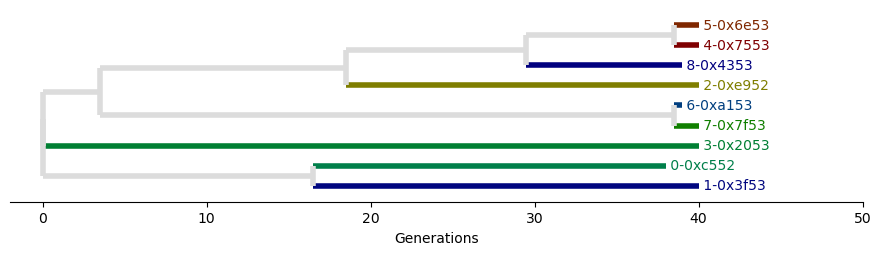

5-0x5cc1
teeplots/genome=hsurftiltedsticky_tagged+replicate=45e8bb23-7e24-4a17-a493-40123f850a36+viz=draw-biopython-tree+ext=.pdf
teeplots/genome=hsurftiltedsticky_tagged+replicate=45e8bb23-7e24-4a17-a493-40123f850a36+viz=draw-biopython-tree+ext=.png


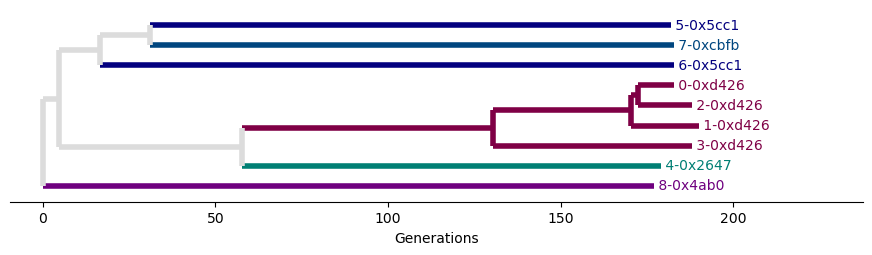

0-0x51fc
teeplots/genome=hsurftiltedsticky_tagged+replicate=a2438095-6857-4a68-bd77-14065953b13c+viz=draw-biopython-tree+ext=.pdf
teeplots/genome=hsurftiltedsticky_tagged+replicate=a2438095-6857-4a68-bd77-14065953b13c+viz=draw-biopython-tree+ext=.png


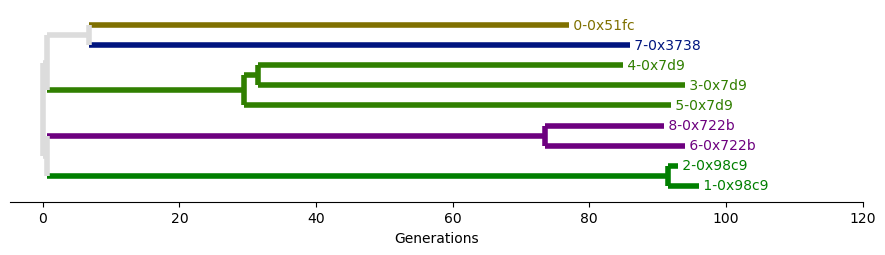

6-0x82c8
teeplots/genome=hsurftiltedsticky_tagged+replicate=c830e722-ad66-48ed-a02f-2aa994dfc268+viz=draw-biopython-tree+ext=.pdf
teeplots/genome=hsurftiltedsticky_tagged+replicate=c830e722-ad66-48ed-a02f-2aa994dfc268+viz=draw-biopython-tree+ext=.png


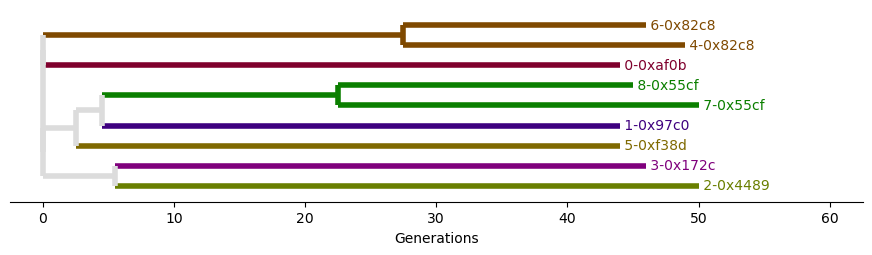

1-0x8aa2
teeplots/genome=hsurftiltedsticky_tagged+replicate=debd0010-f2aa-4679-aac6-b7ce94a2482a+viz=draw-biopython-tree+ext=.pdf
teeplots/genome=hsurftiltedsticky_tagged+replicate=debd0010-f2aa-4679-aac6-b7ce94a2482a+viz=draw-biopython-tree+ext=.png


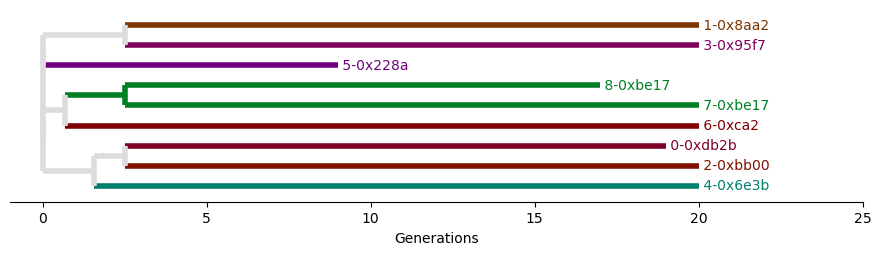

In [57]:
for names, group in df.groupby("replicate"):
    tree_df = hstrat.build_tree(
        group["hstrat_columns"].values,
        hstrat.__version__,
        taxon_labels=group["taxon name"].values,
        force_common_ancestry=True,
    )
    tree_df["name"] = tree_df["taxon_label"]

    biopy_tree = apc.RosettaTree(tree_df).as_biopython
    print(biopy_tree.get_terminals()[0].name)
    color_biopython_tree(biopy_tree.root)

    tp.tee(
        draw_biopython_tree,
        biopy_tree,
        fig_size=(11, 2.5),
        teeplot_outattrs={
            "genome": "hsurftiltedsticky_tagged",
            "replicate": group["replicate"].values[0],
        },
    )


## Random tree


In [58]:
dummy = [random.randint(0, 2**80) for _ in range(9)]
print(make_hamming_distance_matrix(dummy).upgma_tree().as_ascii_plot())


                                                             /--------------- 1
/------------------------------------------------------------+                 
|                                                            \--------------- 6
|                                                                              
+                                                            /--------------- 0
|              /---------------------------------------------+                 
|              |                                             \--------------- 7
|              |                                                               
\--------------+                                             /--------------- 3
               |              /------------------------------+                 
               |              |                              \--------------- 8
               \--------------+                                                
                              |         